In [8]:
!pip install -U spacy
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.2/29.2 MB 59.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 82.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 95.6 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: blis
    Found existing installation: blis 0.7.11
    Uninstalling blis-0.7.11:
      Successfully uninstalled blis-0.7.11
  Attempting uninstall: thinc
    Found existing installation: thinc 8.2.5
    Uninstalling thinc-8.2.5:
      Successfully uninstalled thinc-8.2.5
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.5
    Uninstalling spacy-3.7.5:
      Successfully uninstalled spacy-3.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.7.1 requires spacy<3.8.0,>=3.7.2, but you have spacy 3.8.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━

In [3]:
import tensorflow as tf

# Periksa apakah GPU tersedia
print("GPU Available:", tf.config.list_physical_devices('GPU'))
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv


# 1. Import the Depedencies

In [130]:
import nltk
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
import tensorflow as tf
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import re
import keras
import datetime

define the path

# 2. Load the Dataset

In [5]:
path = "/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv"

In [6]:
df= pd.read_csv(path,sep = "\t")

In [7]:
df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [9]:
df[['verified_reviews', 'rating']].isnull().sum()

verified_reviews    1
rating              0
dtype: int64

In [10]:
df = df.dropna(subset=['verified_reviews','rating'])

In [11]:
round(df['rating'].value_counts(normalize = True)*100,2)

rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: proportion, dtype: float64

<Axes: xlabel='rating', ylabel='count'>

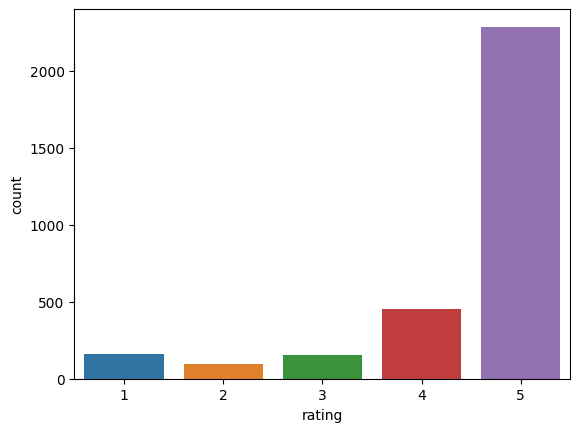

In [12]:
sns.countplot(data = df, x = 'rating')

# 3. Cleaning, Preprocessing, and Tokenization

In [13]:
import spacy
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
        doc = nlp(text)
        return ' '.join([token.lemma_ for token in doc])

def cleaning(df):
    # Konversi semua teks ke huruf kecil
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: 

            ' '.join(x.lower() for x in x.split()))

    # Hapus URL
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))
    
    # Hapus angka
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: re.sub(r'\d+', '', x))
    
    # Hapus tanda baca dan simbol
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    
    # Hapus spasi berlebih
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
    # melakukan lemmatisasi pada kata kata
    df['verified_reviews'] = df['verified_reviews'].apply(lemmatize_text)
    
    
    
    return df


In [14]:
copy_df = df.copy()
df_cleaned = cleaning(copy_df)

In [15]:
df_cleaned

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,love my echo,1
1,5,31-Jul-18,Charcoal Fabric,love it,1
2,4,31-Jul-18,Walnut Finish,sometimes while play a game you can answer a q...,1
3,5,31-Jul-18,Charcoal Fabric,I have have a lot of fun with this thing my yr...,1
4,5,31-Jul-18,Charcoal Fabric,music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,perfect for kid adult and everyone in between,1
3146,5,30-Jul-18,Black Dot,listen to music search location check time loo...,1
3147,5,30-Jul-18,Black Dot,I do love these thing I have they run my entir...,1
3148,5,30-Jul-18,White Dot,only complaint I have be that the sound qualit...,1


## Visualize the most common word

In [16]:
all_words = " ".join(df_cleaned['verified_reviews']).lower().split()
word_freq = pd.Series(all_words).value_counts()


unique_words = len(word_freq)


print("Jumlah kata unik:", unique_words)
print("Frekuensi kata:\n", word_freq)

Jumlah kata unik: 3471
Frekuensi kata:
 i              3536
the            3248
to             2821
be             2763
it             2559
               ... 
reoccurring       1
believer          1
leg               1
cohesive          1
ie                1
Name: count, Length: 3471, dtype: int64


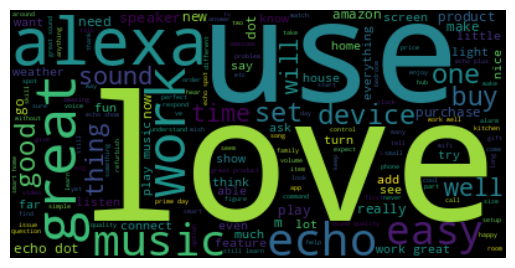

In [ ]:
common_words = ''

for text in df_cleaned.verified_reviews:
    text = str(text)
    tokens = text.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud,interpolation ='bilinear')
plt.axis('off')
plt.show()

In [ ]:
reviews = df_cleaned['verified_reviews']
ratings = df_cleaned['rating']

## Split the Cleaned Data

In [209]:
train_x,test_x, train_y, test_y = train_test_split(reviews,ratings,test_size = 0.2,stratify = ratings,random_state = 88)

decrement by 1 for 0-indexing

In [210]:
train_y-=1
test_y-=1

## Tokenize and Add Padding

In [211]:

vocab_size = 3471
tokenizer = Tokenizer(num_words = vocab_size, oov_token="")
tokenizer.fit_on_texts(train_x)
word_index = tokenizer.word_index
train_x = tokenizer.texts_to_sequences(train_x)
train_x_padded = pad_sequences(train_x, padding = "post", maxlen = 150)

test_x = tokenizer.texts_to_sequences(test_x)
test_x_padded = pad_sequences(test_x, padding = "post", maxlen = 150)


 # 4. Model Preparation and Training

In [216]:
LSTM_model = Sequential([
    Embedding(vocab_size, 140, input_length = 150),
    SpatialDropout1D(0.4),
    keras.layers.Bidirectional(LSTM(256,dropout =0.3,recurrent_dropout =0.3)),
    Dense(24, activation = 'relu'),
    Dense(5, activation = 'softmax')
])

In [217]:
optim = keras.optimizers.Adam(learning_rate= 0.0001)

In [218]:
LSTM_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [219]:
from keras.callbacks import EarlyStopping

# Membuat callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=13,           
    verbose=1,            
    restore_best_weights=True  # Mengembalikan bobot terbaik
)

In [220]:
epochs = 75
history = LSTM_model.fit(train_x_padded, train_y, epochs = epochs,verbose = 1, validation_split = 0.1,batch_size = 256, callbacks = [early_stopping])

Epoch 1/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 388ms/step - accuracy: 0.5759 - loss: 1.3238 - val_accuracy: 0.7500 - val_loss: 0.9058
Epoch 2/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.7175 - loss: 0.9327 - val_accuracy: 0.7500 - val_loss: 0.8817
Epoch 3/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - accuracy: 0.7302 - loss: 0.8690 - val_accuracy: 0.7500 - val_loss: 0.8603
Epoch 4/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.7123 - loss: 0.8829 - val_accuracy: 0.7500 - val_loss: 0.8107
Epoch 5/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.7276 - loss: 0.8081 - val_accuracy: 0.7500 - val_loss: 0.7718
Epoch 6/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - accuracy: 0.7296 - loss: 0.7740 - val_accuracy: 0.7460 - val_loss: 0.7465
Epoch 7/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - accuracy: 0.7429 - loss: 0.7003 - val_accuracy: 0.7659 - val_loss: 0.7121
Epoch 8/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step - accuracy: 0.7435 - loss: 0.6809 - val_accuracy: 0.7579 - val_loss:

In [221]:
def test_model(model, true_label):
    y_pred = model.predict(test_x_padded)
    y_pred = np.argmax(y_pred,axis=1)
    print(classification_report(true_label,y_pred))

test_model(LSTM_model,test_y)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step
              precision    recall  f1-score   support

           0       0.75      0.47      0.58        32
           1       0.71      0.26      0.38        19
           2       0.51      0.58      0.55        31
           3       0.52      0.47      0.49        91
           4       0.86      0.91      0.89       457

    accuracy                           0.79       630
   macro avg       0.67      0.54      0.58       630
weighted avg       0.78      0.79      0.78       630



# 5. Visualizing and Evaluating result 

In [222]:
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

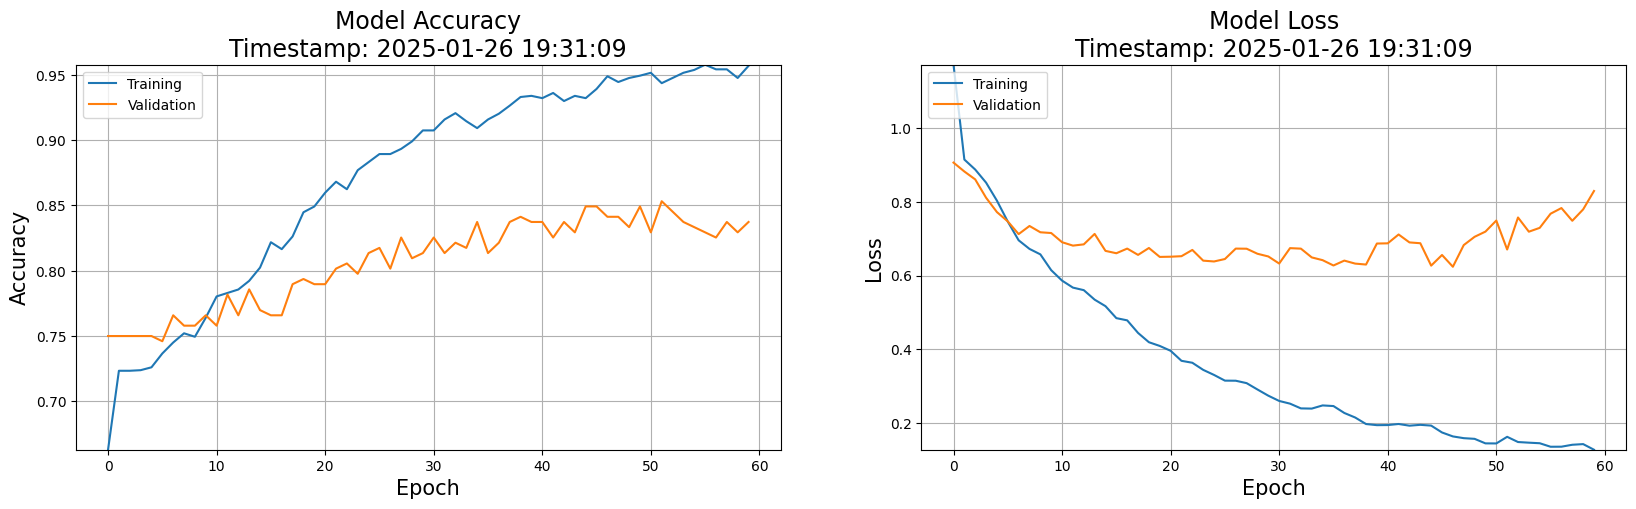

In [223]:

def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

plot_performance(history)

# 6. Save the Model

In [225]:
LSTM_model.save('/kaggle/working/5class_Amazon_Alexa_LSTM_weight.h5')